<a href="https://colab.research.google.com/github/dantepawn/data_viz/blob/master/covid19v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required

In [1]:
!pip install geopandas

     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.4MB 35.5MB/s 
     |████████████████████████████████| 14.7MB 33.8MB/s 


In [2]:
#dependencies
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import datetime 
import folium
#from folium.plugins import  HeatMap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

In [0]:
#month.days format  
days = ['0306','0307','0308','0309','0310','0311','0312','0313','0314','0315','0316','0317','0318','0319','0320','0321','0322','0323','0324','0325','0326','0327','0328','0329','0330','0331','0401','0402','0403','0404','0405','0406','0407']
#or 


In [0]:
def create_df(days):
  '''for each day in days collect the data of ''' 
  df = pd.DataFrame()

  for i in days:
    url =  'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province-2020{}.csv'.format(i)
  #df.append(pd.read_csv(url, encoding= 'Latin'))
    df = pd.concat([df,pd.read_csv(url, encoding="Latin")])
    df.data = pd.to_datetime(df.data , yearfirst=True)
    df = df[df['codice_provincia'].map(lambda x :len(str(x)) < 3)]
    #rename regions
    df['denominazione_regione'] = df['denominazione_regione'].mask(df['denominazione_regione']=='P.A. Bolzano', 'Trentino-Alto Adige')
    df['denominazione_regione'] = df['denominazione_regione'].mask(df['denominazione_regione']=='P.A. Trento', 'Trentino-Alto Adige')
  return df


In [0]:
#region shape json file
regioni_url = 'https://gist.github.com/datajournalism-it/48e29e7c87dca7eb1d29/raw/2636aeef92ba0770a073424853f37690064eb0ea/regioni.geojson'
regioni = gpd.read_file(regioni_url)
regioni.rename(columns={'NOME_REG':'denominazione_regione'},inplace=True)

In [0]:
regioni.denominazione_regione.values

array(['Piemonte', "Valle d'Aosta", 'Lombardia', 'Trentino-Alto Adige',
       'Veneto', 'Friuli Venezia Giulia', 'Liguria', 'Emilia-Romagna',
       'Toscana', 'Umbria', 'Marche', 'Lazio', 'Abruzzo', 'Molise',
       'Campania', 'Puglia', 'Basilicata', 'Calabria', 'Sicilia',
       'Sardegna'], dtype=object)

In [0]:
#popolazione regionale 
popolazione = "Lombardia,Lazio,Campania,Sicilia,Veneto,Emilia-Romagna,Piemonte,Puglia,Toscana,Calabria,Sardegna,Liguria,Marche,Abruzzo,Friuli Venezia Giulia,Trentino-Alto Adige,Umbria,Basilicata,Molise,Valle d'Aosta".split(',')
nu = [10060574,5879082,5801692,4999891,4905854	,4459477,4356406	,4029053,3729641,1947131,1639591,1550640,1525271	,1311580,1215220,1072276	,882015,562869	,305617	,125666]
popolazione = dict(zip(popolazione,nu))

In [0]:
popolazione

{'Abruzzo': 1311580,
 'Basilicata': 562869,
 'Calabria': 1947131,
 'Campania': 5801692,
 'Emilia-Romagna': 4459477,
 'Friuli Venezia Giulia': 1215220,
 'Lazio': 5879082,
 'Liguria': 1550640,
 'Lombardia': 10060574,
 'Marche': 1525271,
 'Molise': 305617,
 'Piemonte': 4356406,
 'Puglia': 4029053,
 'Sardegna': 1639591,
 'Sicilia': 4999891,
 'Toscana': 3729641,
 'Trentino-Alto Adige': 1072276,
 'Umbria': 882015,
 "Valle d'Aosta": 125666,
 'Veneto': 4905854}

In [0]:
df = create_df(days)
df.shape

(3267, 12)

In [0]:
#pd.DataFrame(regioni).to_json('regioni.json')

In [0]:
df.tail()

data stato  codice_regione  ... totale_casi  note_it note_en
122 2020-04-07 17:00:00   ITA               5  ...         218      NaN     NaN
123 2020-04-07 17:00:00   ITA               5  ...        1738      NaN     NaN
124 2020-04-07 17:00:00   ITA               5  ...        1543      NaN     NaN
125 2020-04-07 17:00:00   ITA               5  ...        2856      NaN     NaN
126 2020-04-07 17:00:00   ITA               5  ...        1734      NaN     NaN

[5 rows x 12 columns]

merge with each region shape

In [0]:
#merge df with regions to include the geo
gdf = df.merge(regioni , on = ['denominazione_regione'])

In [0]:
gdf.set_index('data',inplace=True)

In [0]:
gdf.head(2)

stato  ...                                           geometry
data                       ...                                                   
2020-03-06 18:00:00   ITA  ...  MULTIPOLYGON (((13.92027 42.89005, 13.92045 42...
2020-03-06 18:00:00   ITA  ...  MULTIPOLYGON (((13.92027 42.89005, 13.92045 42...

[2 rows x 12 columns]

In [0]:
df.reset_index().totale_casi

0          3
1          1
2          1
3          4
4          4
        ... 
2155     125
2156    1402
2157    1067
2158    1876
2159    1104
Name: totale_casi, Length: 2160, dtype: object

In [0]:
#example case
df_cases = df[(df['denominazione_provincia'] == 'Roma') | 
   (df['denominazione_provincia'] == 'Bergamo') | 
   (df['denominazione_provincia'] == 'Milano') |
   (df['denominazione_provincia'] == 'Bologna')|
   (df['denominazione_provincia'] == 'Catania')] 


In [0]:
df_cases=df_cases.set_index('data')

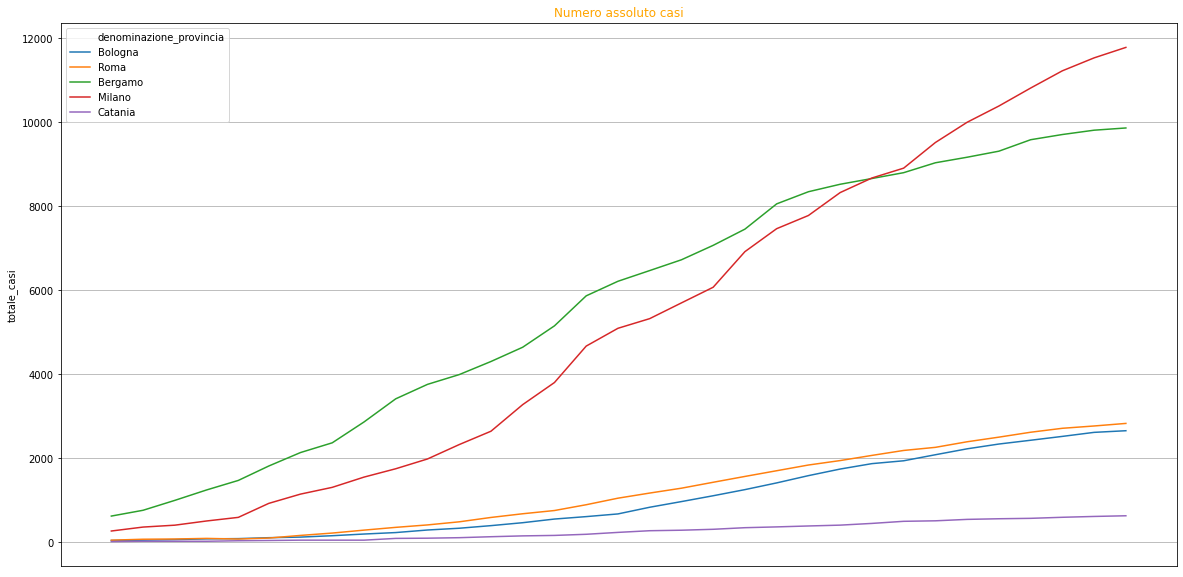

In [0]:
citta = ['Roma','Milano','Bergamo','Catania','Bologna']
plt.figure(figsize = (20,10))
plt.title('Numero assoluto casi', color = 'orange')
plt.xticks([])
  #plt.title(citta[i-1], color = 'orange')
plt.grid(axis = 'y')
sn.lineplot(x = df_cases.index , y = 'totale_casi' , hue = 'denominazione_provincia'  , data = df_cases )

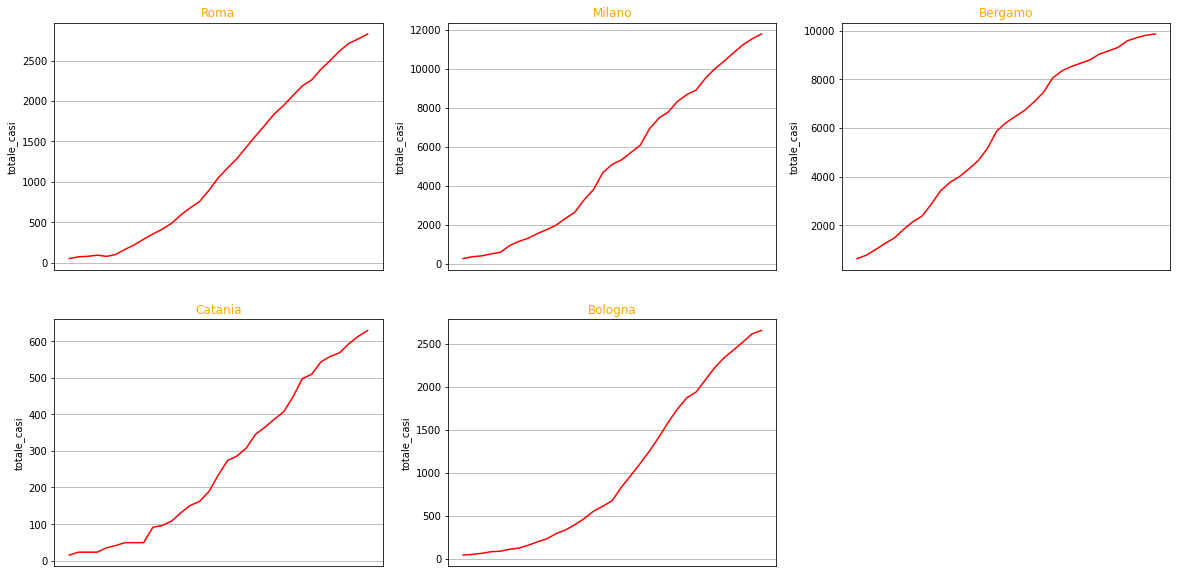

In [0]:
citta = ['Roma','Milano','Bergamo','Catania','Bologna']
plt.figure(figsize = (20,10))
plt.title('Numero assoluto casi', color = 'orange')

for i in range(1,len(citta)+1):
  plt.subplot(2,3,i)
  data= df_cases[df_cases['denominazione_provincia'] == citta[i-1] ] 
  plt.xticks([])
  plt.title(citta[i-1], color = 'orange')
  plt.grid(axis = 'y')
  
  sn.lineplot(x = data.index , y = 'totale_casi' , data = data ,color= 'red', legend='full')

In [0]:
#Overall total

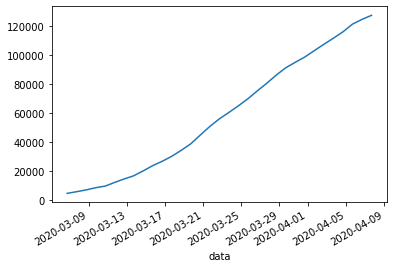

In [0]:
df.groupby('data')['totale_casi'].sum().plot()

In [0]:
df_cases.head(1)

ERROR! Session/line number was not unique in database. History logging moved to new session 60


stato  codice_regione  ... note_it  note_en
data                                       ...                 
2020-03-06 18:00:00   ITA               8  ...     NaN      NaN

[1 rows x 11 columns]

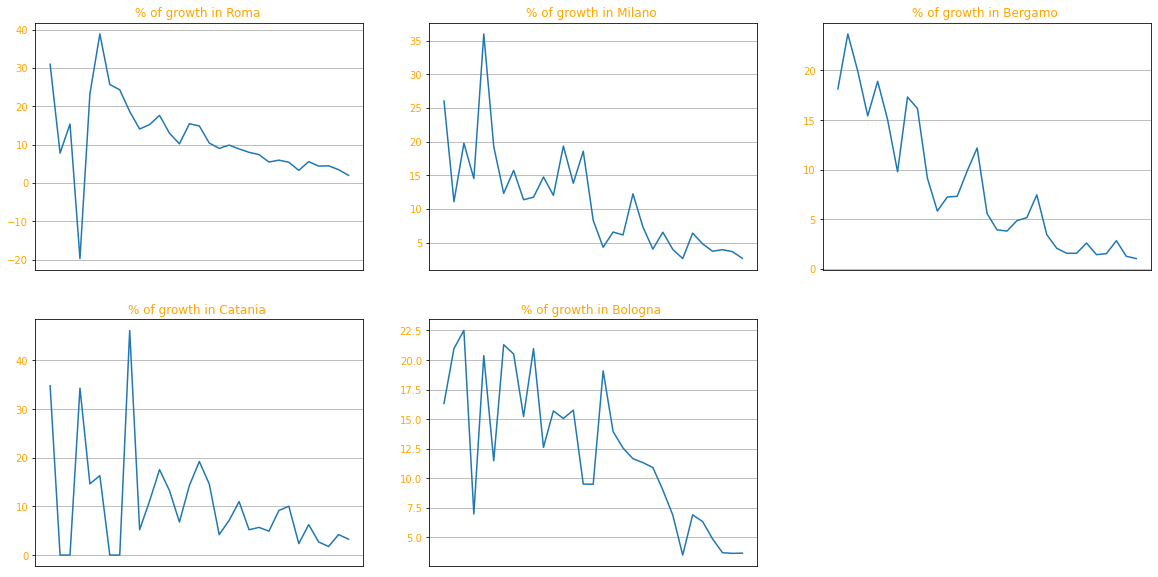

In [0]:
citta = ['Roma','Milano','Bergamo','Catania','Bologna']
plt.figure(figsize = (20,10))

for i in range(0,len(citta)):
  plt.subplot(2,3,i+1)
  data= df_cases[df_cases['denominazione_provincia'] == citta[i] ] 
  
  numbers = data.totale_casi.values
  np.set_printoptions(suppress= True)
  perc = (numbers - np.pad(numbers, 1)[:-2])/numbers
  plt.title('% of growth in {} '.format(citta[i]), color = 'orange')
  plt.grid(which = 'both',axis = 'y' )
  plt.yticks(color= 'orange')
  plt.xticks([])
  plt.plot(100*perc[1:-1])

# Folium visualization


In [0]:
#base = folium.Map(location= (41.9028, 12.4964), tiles = 'Stamentoner' , zoom_start = 6 )
#base

In [0]:
df.set_index('data')['2020-03-30'].head(2)

stato  codice_regione  ... note_it  note_en
data                                       ...                 
2020-03-30 17:00:00   ITA              13  ...     NaN      NaN
2020-03-30 17:00:00   ITA              13  ...     NaN      NaN

[2 rows x 11 columns]

In [0]:
when = '2020-04-06'
base = folium.Map(location= (41.9028, 12.4964), tiles = 'CartoDBPositron' , zoom_start = 6 ,)
for i , row in df.set_index('data')[when].iterrows():
  folium.Circle(location=(row.lat,row.long) , radius = row.totale_casi*10 , color = 'green' ,fill = True  ).add_to(base)

In [0]:
base


# Plot by regions

In [0]:
when = '2020-04-05'
df.set_index('data')[when].head()

stato  codice_regione  ... note_it  note_en
data                                       ...                 
2020-04-05 17:00:00   ITA              13  ...     NaN      NaN
2020-04-05 17:00:00   ITA              13  ...     NaN      NaN
2020-04-05 17:00:00   ITA              13  ...     NaN      NaN
2020-04-05 17:00:00   ITA              13  ...     NaN      NaN
2020-04-05 17:00:00   ITA              17  ...     NaN      NaN

[5 rows x 11 columns]

In [0]:
len(df.set_index('data')[when].denominazione_regione.unique()) , len(regioni.denominazione_regione	)

(20, 20)

In [0]:
#df = df.where(df['denominazione_regione'].any( ['P.A. Bolzano' , 'P.A. Trento']),other ='Trentino-Alto Adige' ) 


In [0]:
import json
import requests

In [0]:
geo_json_regioni = json.loads(requests.get(regioni_url).text)

In [0]:
base = folium.Map(location= (41.9028, 12.4964), tiles = 'CartoDBPositron' , zoom_start = 6)
folium.GeoJson(geo_json_regioni).add_to(base)
#to save
#m.save(os.path.join('results', 'GeoJSON_and_choropleth_0.html'))

In [0]:
#base

you can pass a geopandas dataframe

In [0]:
gdf.set_index('data',inplace=True)

In [0]:
gdf.denominazione_regione.unique()

array(['Abruzzo', 'Basilicata', 'Trentino-Alto Adige', 'Calabria',
       'Campania', 'Emilia-Romagna', 'Friuli Venezia Giulia', 'Lazio',
       'Liguria', 'Lombardia', 'Marche', 'Molise', 'Piemonte', 'Puglia',
       'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta",
       'Veneto'], dtype=object)

In [0]:
#base = folium.Map(location= (41.9028, 12.4964), tiles = 'CartoDBPositron' , zoom_start = 6)

gdf_example = gdf['2020-04-05'].groupby('denominazione_regione')['totale_casi'].sum()
#folium.GeoJson(gdf_example).add_to(base)


In [0]:
gdf_example = pd.merge(pd.Series(popolazione, name = 'popolazione' ),gdf_example , left_index=True  , right_index=True)


In [0]:
gdf_example

popolazione  totale_casi
Lombardia                 10060574        46277
Lazio                      5879082         3851
Campania                   5801692         2732
Sicilia                    4999891         1994
Veneto                     4905854        10940
Emilia-Romagna             4459477        17089
Piemonte                   4356406        11577
Puglia                     4029053         2150
Toscana                    3729641         5509
Calabria                   1947131          624
Sardegna                   1639591          836
Liguria                    1550640         3689
Marche                     1525271         4058
Abruzzo                    1311580         1703
Friuli Venezia Giulia      1215220         2042
Trentino-Alto Adige        1072276         3929
Umbria                      882015         1200
Basilicata                  562869          278
Molise                      305617          210
Valle d'Aosta               125666          782

In [0]:
cases_over_1000 = 1000*gdf_example['totale_casi'] / gdf_example['popolazione']

Create a color map

In [0]:
from branca.colormap import linear 

#to create the color map
min_col = cases_over_1000.min()
max_col = cases_over_1000.max()

colormap = linear.YlGn_09.scale(min_col,max_col)

print(colormap(5.0))

colormap

#177a3fff


In [0]:
cases_over_1000

Lombardia                4.599837
Lazio                    0.655034
Campania                 0.470897
Sicilia                  0.398809
Veneto                   2.229989
Emilia-Romagna           3.832064
Piemonte                 2.657466
Puglia                   0.533624
Toscana                  1.477086
Calabria                 0.320472
Sardegna                 0.509883
Liguria                  2.379018
Marche                   2.660511
Abruzzo                  1.298434
Friuli Venezia Giulia    1.680354
Trentino-Alto Adige      3.664169
Umbria                   1.360521
Basilicata               0.493898
Molise                   0.687135
Valle d'Aosta            6.222845
dtype: float64

In [0]:
color_dic = {key:  colormap(values) for key,values in cases_over_1000.items() }

In [0]:
color_dic

{'Abruzzo': '#eef9b2ff',
 'Basilicata': '#feffdbff',
 'Calabria': '#ffffe5ff',
 'Campania': '#feffdcff',
 'Emilia-Romagna': '#4eb264ff',
 'Lazio': '#fcfed1ff',
 'Liguria': '#b6e192ff',
 'Lombardia': '#298c48ff',
 'Marche': '#a4d98aff',
 'Molise': '#fcfecfff',
 'Piemonte': '#a4d98bff',
 'Puglia': '#fdffd9ff',
 'Sardegna': '#fdffdaff',
 'Sicilia': '#ffffe1ff',
 'Toscana': '#e6f6adff',
 'Trentino-Alto Adige': '#5bb86aff',
 'Umbria': '#ebf8b0ff',
 "Valle d'Aosta": '#004529ff',
 'Veneto': '#bfe597ff'}

[this is the example it is taken from](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/GeoJSON_and_choropleth.ipynb)

In [0]:
base = folium.Map(location= (41.9028, 12.4964), tiles = 'CartoDBPositron' , zoom_start = 6)

folium.GeoJson(
    geo_json_regioni,
    name='NOME_REG',
    style_function= lambda feature : {
        'fillColor': color_dic[feature['properties']['NOME_REG']],
        'color': 'black',
        'weight': 1,
        #'dashArray': '5, 5',
        'fillOpacity': 0.7,
    }
).add_to(base)

folium.LayerControl().add_to(base)


#m.save(os.path.join('results', 'GeoJSON_and_choropleth_5.html'))

base

In [0]:

folium.GeoJson(geo_json_data).add_to(base)

In [0]:
df.columns

Index(['stato', 'codice_regione', 'denominazione_regione', 'codice_provincia',
       'denominazione_provincia', 'sigla_provincia', 'lat', 'long',
       'totale_casi', 'note_it', 'note_en', 'geometry'],
      dtype='object')

In [0]:
df_grouped = df.groupby(['data','denominazione_regione'])['totale_casi'].sum()
df_grouped

data                 denominazione_regione
2020-03-06 18:00:00  Abruzzo                     9.0
                     Basilicata                  3.0
                     Calabria                    4.0
                     Campania                   17.0
                     Emilia-Romagna            870.0
                                               ...  
2020-03-31 17:00:00  Toscana                  4350.0
                     Trentino-Alto Adige      3117.0
                     Umbria                   1043.0
                     Valle d'Aosta             628.0
                     Veneto                   8876.0
Name: totale_casi, Length: 520, dtype: float64

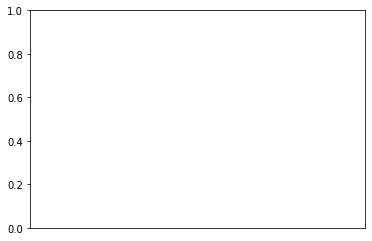

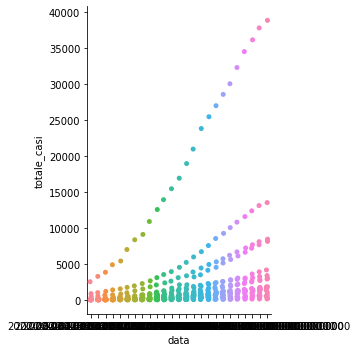

In [0]:
sn.catplot(x='data',y = 'totale_casi',data= df_grouped.reset_index())# dfgrouped

In [0]:
df_grouped.reset_index().set_index('data')['2020-03-27']

denominazione_regione  totale_casi
data                                                   
2020-03-27 17:00:00                Abruzzo       1017.0
2020-03-27 17:00:00             Basilicata        151.0
2020-03-27 17:00:00               Calabria        383.0
2020-03-27 17:00:00               Campania       1354.0
2020-03-27 17:00:00         Emilia-Romagna      11588.0
2020-03-27 17:00:00  Friuli Venezia Giulia       1309.0
2020-03-27 17:00:00                  Lazio       2273.0
2020-03-27 17:00:00                Liguria       1467.0
2020-03-27 17:00:00              Lombardia      34545.0
2020-03-27 17:00:00                 Marche       2909.0
2020-03-27 17:00:00                 Molise        100.0
2020-03-27 17:00:00               Piemonte       6622.0
2020-03-27 17:00:00                 Puglia       1187.0
2020-03-27 17:00:00               Sardegna        480.0
2020-03-27 17:00:00                Sicilia       1250.0
2020-03-27 17:00:00                Toscana       3036.0
2020-03-27 17:00:00    Trentino-Alto Adige       2394.0
2020-03-27 17:00:00                 Umbria        853.0
2020-03-27 17:00:00          Valle d'Aosta        452.0
2020-03-27 17:00:00                 Veneto       7218.0

In [0]:
df_grouped = df.groupby(['data','denominazione_regione'])['totale_casi'].sum()
df_target = df_grouped.reset_index().set_index('data')['2020-03-29']
df_target = pd.DataFrame(df_target)

In [0]:
df_target.set_index('denominazione_regione')

totale_casi
denominazione_regione             
Abruzzo                     1293.0
Basilicata                   202.0
Calabria                     483.0
Campania                    1647.0
Emilia-Romagna             13119.0
Friuli Venezia Giulia       1471.0
Lazio                       2691.0
Liguria                     1732.0
Lombardia                  37841.0
Marche                      3251.0
Molise                       117.0
Piemonte                    7666.0
Puglia                      1385.0
Sardegna                     583.0
Sicilia                     1460.0
Toscana                     3901.0
Trentino-Alto Adige         2808.0
Umbria                       993.0
Valle d'Aosta                584.0
Veneto                      8094.0

In [0]:
#check all the region names correspond 
for v in df_target.denominazione_regione:
  if v in regioni.denominazione_regione.values :
    print(True)
  else:
    print(False)  


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [0]:
#bins = list(df_target['totale_casi'].quantile([0, 0.25, 0.5, 0.75, 1]))

In [0]:
#help(folium.Choropleth)

In [0]:
regioni.to_file("regioni.geojson", driver='GeoJSON')

so the geo_data flag has to be a json file ?? , so download the file and use the address


In [0]:
df_target.head()

denominazione_regione  totale_casi
data                                                  
2020-03-29 17:00:00               Abruzzo       1293.0
2020-03-29 17:00:00            Basilicata        202.0
2020-03-29 17:00:00              Calabria        483.0
2020-03-29 17:00:00              Campania       1647.0
2020-03-29 17:00:00        Emilia-Romagna      13119.0

In [0]:
base = folium.Map(location= (41.9028, 12.4964) , zoom_start = 6 )
#base = folium.Map(location= (41.9028, 12.4964), tiles = 'Stamentoner' , zoom_start = 6 )
#bins = list(df_target['totale_casi'].quantile([0, 0.25, 0.5, 0.75, 1]))



folium.Choropleth(
    geo_data = "regioni.geojson",
    name = 'choropleth',
    data = df_target,
    columns = ['denominazione_regione','totale_casi'] ,
    key_on ='regioni.denominazione_regione',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Casi Totali',
    
    
).add_to(base)

folium.LayerControl().add_to(base)

base

AttributeError: ignored

In [0]:
series_target = df_target.set_index('denominazione_regione')

In [0]:
series_target.iloc[:,0]

denominazione_regione
Abruzzo                   1293.0
Basilicata                 202.0
Calabria                   483.0
Campania                  1647.0
Emilia-Romagna           13119.0
Friuli Venezia Giulia     1471.0
Lazio                     2691.0
Liguria                   1732.0
Lombardia                37841.0
Marche                    3251.0
Molise                     117.0
Piemonte                  7666.0
Puglia                    1385.0
Sardegna                   583.0
Sicilia                   1460.0
Toscana                   3901.0
Trentino-Alto Adige       2808.0
Umbria                     993.0
Valle d'Aosta              584.0
Veneto                    8094.0
Name: totale_casi, dtype: float64

In [0]:
base = folium.Map(location= (41.9028, 12.4964) , zoom_start = 6 )
#base = folium.Map(location= (41.9028, 12.4964), tiles = 'Stamentoner' , zoom_start = 6 )
#bins = list(df_target['totale_casi'].quantile([0, 0.25, 0.5, 0.75, 1]))



folium.Choropleth(
    geo_data = regioni.__geo_interface__,
    name = 'choropleth',
    data = series_target.iloc[:,0],
    #columns = ['denominazione_regione','totale_casi'] ,
    key_on ='feature.denominazione_regione',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Casi Totali',
    
    
).add_to(base)

folium.LayerControl().add_to(base)

#base

# Geopandas visualization


In [0]:
df = create_df(days)
gdf = df.merge(regioni , on = ['denominazione_regione'])
gdf = gdf.set_index('data')

In [0]:
gdf.tail()

stato  ...                                           geometry
data                       ...                                                   
2020-04-04 17:00:00   ITA  ...  MULTIPOLYGON (((12.50591 46.67839, 12.50603 46...
2020-04-04 17:00:00   ITA  ...  MULTIPOLYGON (((12.50591 46.67839, 12.50603 46...
2020-04-04 17:00:00   ITA  ...  MULTIPOLYGON (((12.50591 46.67839, 12.50603 46...
2020-04-04 17:00:00   ITA  ...  MULTIPOLYGON (((12.50591 46.67839, 12.50603 46...
2020-04-04 17:00:00   ITA  ...  MULTIPOLYGON (((12.50591 46.67839, 12.50603 46...

[5 rows x 12 columns]

In [0]:
gdf_reg = gdf['2020-03-26'].groupby(['denominazione_regione'])['totale_casi'].sum()

In [0]:
gdf_reg

denominazione_regione
Abruzzo                    946
Basilicata                 134
Calabria                   283
Campania                  1280
Emilia-Romagna           10816
Friuli Venezia Giulia     1215
Lazio                     2092
Liguria                   1331
Lombardia                32332
Marche                    2859
Molise                      94
Piemonte                  6106
Puglia                    1065
Sardegna                   473
Sicilia                   1164
Toscana                   3036
Trentino-Alto Adige       2203
Umbria                     778
Valle d'Aosta              408
Veneto                    6675
Name: totale_casi, dtype: int64

In [0]:
#taday is automatically set to yesteday
yesterday = datetime.date.today() -datetime.timedelta(3)
#gdf[str(today)]

def region_plot(day = yesterday):
  fig, ax = plt.subplots(figsize= (10,8))
  plt.xticks([])
  plt.yticks([])
  gdf_reg = gdf[str(day)].groupby(['denominazione_regione'])['totale_casi'].sum()
  #merge with the json shape file
  gdf_reg = regioni.merge(gdf_reg , on ='denominazione_regione')
  #merge with popolazione to normalize
  gdf_reg.plot(column = 'totale_casi per 1000 abitanti' , cmap = 'inferno' , legend =True  , ax = ax)



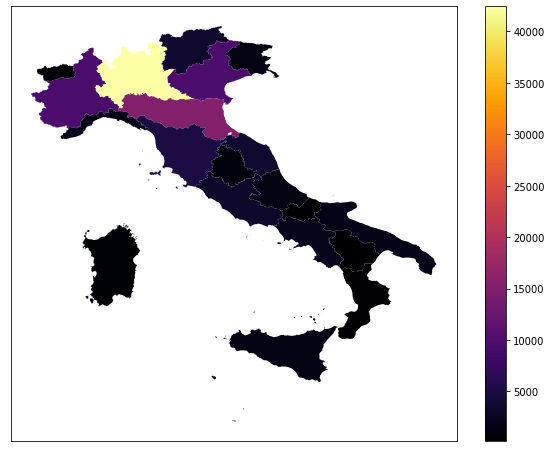

In [0]:
region_plot('2020-04-02')

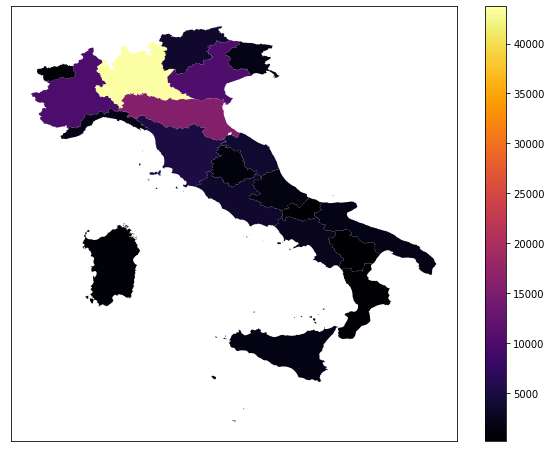

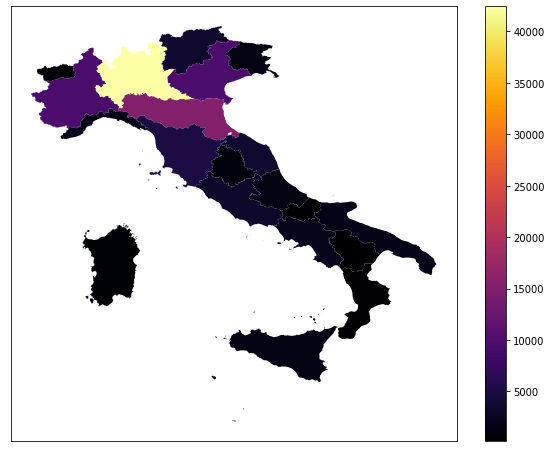

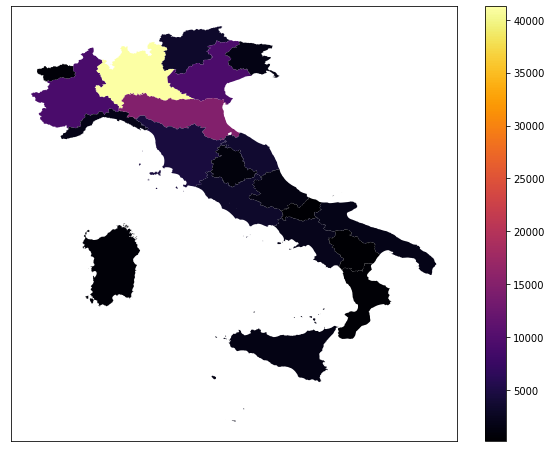

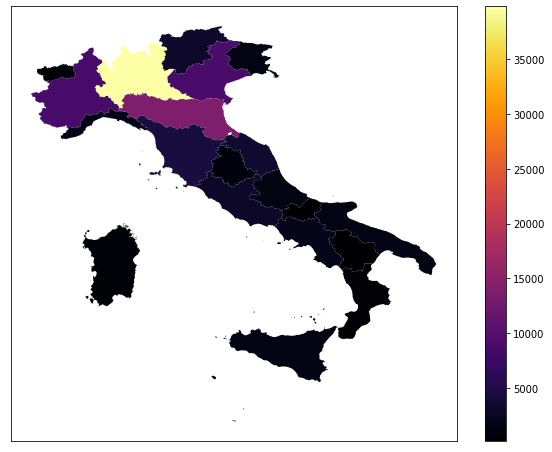

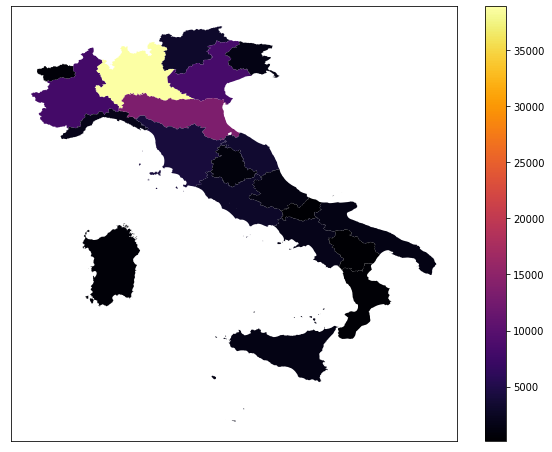

In [0]:
for i in range(0,5):
  region_plot(str(datetime.date.today()-datetime.timedelta(i+3)))

### growth rate per region

In [0]:
# growth rate per region over 3 days
gdf_reg1 = gdf['2020-03-31'].groupby(['denominazione_regione'])['totale_casi'].sum()
gdf_reg2 = gdf['2020-04-01'].groupby(['denominazione_regione'])['totale_casi'].sum()
gdf_reg3 = gdf['2020-04-02'].groupby(['denominazione_regione'])['totale_casi'].sum()
gdf_reg4 = gdf['2020-04-03'].groupby(['denominazione_regione'])['totale_casi'].sum()

(100*(gdf_reg4-gdf_reg3)/gdf_reg3 + 100*(gdf_reg3-gdf_reg2)/gdf_reg2 + 100*(gdf_reg2-gdf_reg1)/gdf_reg1) /4
#over 1 day
reg_growth = 100*(gdf_reg2-gdf_reg1)/gdf_reg1
average_growth = (100*(gdf_reg4-gdf_reg3)/gdf_reg3 + 100*(gdf_reg3-gdf_reg2)/gdf_reg2 + 100*(gdf_reg2-gdf_reg1)/gdf_reg1) /4

In [0]:
gdf['2020-04-01']

Empty DataFrame
Columns: [stato, codice_regione, denominazione_regione, codice_provincia, denominazione_provincia, sigla_provincia, lat, long, totale_casi, note_it, note_en, geometry]
Index: []

In [0]:
def region_growth_plot(reg_growth = reg_growth):
  fig, ax = plt.subplots(figsize= (10,8)  )

  plt.xticks([])
  plt.yticks([])
  gdf_reg= regioni.merge(reg_growth, on ='denominazione_regione')
  gdf_reg.plot(column = 'totale_casi' , cmap = 'inferno' , legend =True  , ax = ax , facecolor = 'grey')

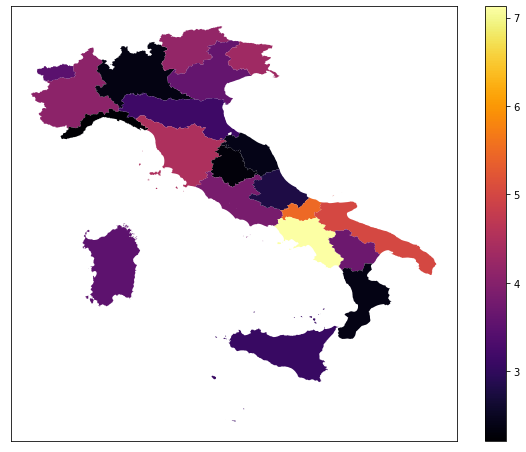

In [0]:
#3 days average growth
region_growth_plot(average_growth)

# Global trend

source : [https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data)

In [0]:
global_death_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
global_confirmed_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
global_recovered_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
#gpd.read_file(global_url)

In [0]:
death_df  = pd.read_csv(global_death_url)
confirmed_df  = pd.read_csv(global_confirmed_url)
recovered_df  = pd.read_csv(global_recovered_url)


(256, 75)

In [0]:
death_df[death_df['Country/Region']=='Italy']
#global_death_df[global_death_df['Country/Region']=='Italy'].iloc[:,4:].values[0]
#global_death_df[global_death_df['Country/Region']=='Italy'].iloc[:,4:].values[0]
#global_url[global_df['Country/Region']=='Italy']

Province/State Country/Region   Lat  Long  ...  4/2/20  4/3/20  4/4/20  4/5/20
137            NaN          Italy  43.0  12.0  ...   13915   14681   15362   15887

[1 rows x 79 columns]

No handles with labels found to put in legend.


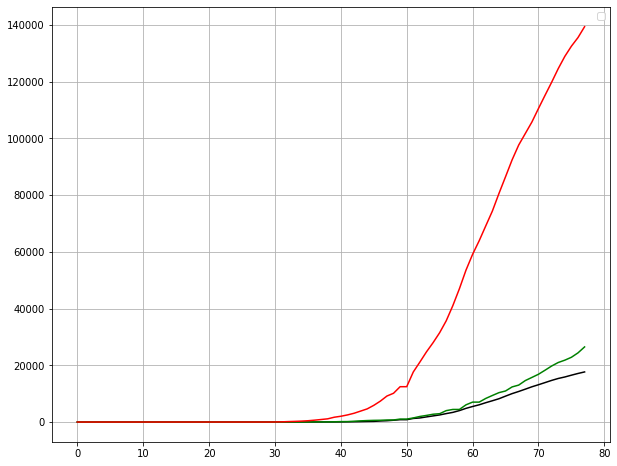

In [40]:
plt.figure(figsize = (10,8))
plt.plot(death_df[death_df['Country/Region']=='Italy'].iloc[:,4:].values[0] , c = 'black' ,  )
plt.plot(recovered_df[recovered_df['Country/Region']=='Italy'].iloc[:,4:].values[0] , c = 'green')
plt.plot(confirmed_df[confirmed_df['Country/Region']=='Italy'].iloc[:,4:].values[0] , c = 'red')
plt.grid()


### Plot growth rate day to day to regions!!!

In [0]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [0]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [9]:
world.head()

pop_est  ...                                           geometry
0     920938  ...  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...
1   53950935  ...  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...
2     603253  ...  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...
3   35623680  ...  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...
4  326625791  ...  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

[5 rows x 6 columns]

In [0]:
# united states of america -> US
world.loc[:,'name'].replace('United States of America','US' , inplace = True)
#world.loc[world.name == 'United States of America'] = 'US'

In [10]:
#rename the column
[x for x in global_confirmed_df.rename({'Country/Region':'name'} , axis = 1).name.values if 'U' in x]

['Uganda',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom',
 'United Kingdom',
 'United Kingdom',
 'United Kingdom',
 'United Kingdom',
 'United Kingdom',
 'United Kingdom',
 'Uruguay',
 'US',
 'Uzbekistan',
 'United Kingdom',
 'United Kingdom',
 'United Kingdom',
 'United Kingdom']

In [0]:
confirmed_df.rename({'Country/Region':'name'} , axis = 1 , inplace = True)

In [45]:
confirmed_df.head()

Province/State         name      Lat     Long  ...  4/5/20  4/6/20  4/7/20  4/8/20
0            NaN  Afghanistan  33.0000  65.0000  ...     349     367     423     444
1            NaN      Albania  41.1533  20.1683  ...     361     377     383     400
2            NaN      Algeria  28.0339   1.6596  ...    1320    1423    1468    1572
3            NaN      Andorra  42.5063   1.5218  ...     501     525     545     564
4            NaN       Angola -11.2027  17.8739  ...      14      16      17      19

[5 rows x 82 columns]

In [48]:
confirmed_df.columns[4:].values

array(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20',
       '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20',
       '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20',
       '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20',
       '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20',
       '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20',
       '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20',
       '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20',
       '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20', '3/27/20',
       '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20', '4/2/20',
       '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20'],
      dtype=object)

In [0]:
confirmed_df = confirmed_df.groupby('name')[confirmed_df.columns[4:].values].sum()

In [0]:
confirmed_df.iloc[:,1:] = 100*(confirmed_df.iloc[:,1:].values - confirmed_df.iloc[:,:-1].values)/(confirmed_df.iloc[:,:-1].values+np.ones((184,77)))

In [0]:
world_global_confirmed = world.merge(confirmed_df, on ='name')

In [83]:
world_global_confirmed.iloc[:,6:].max().max()
world_global_confirmed.iloc[:,6:].min().min()

-71.42857142857143

Growth in  percentage

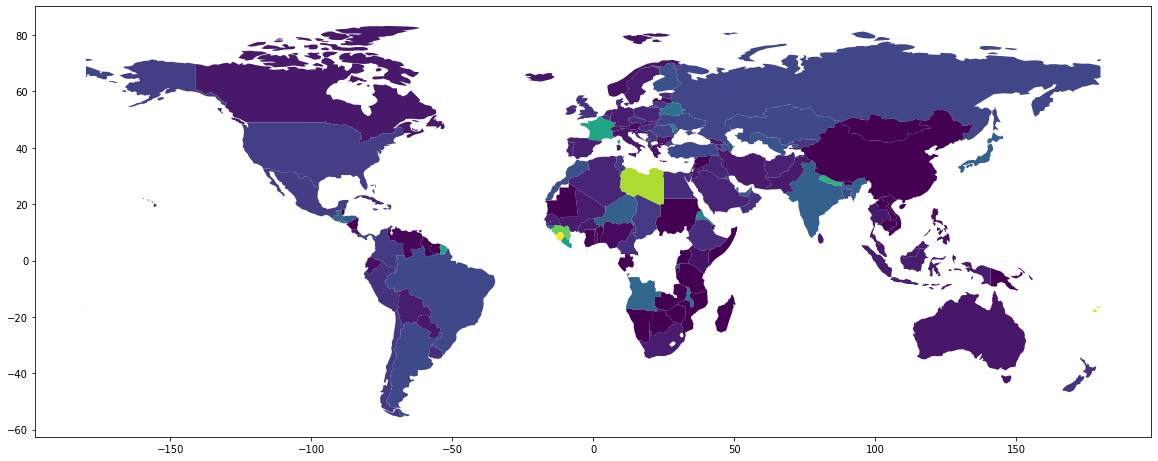

In [84]:
fig, ax = plt.subplots(figsize= (20,30))
world_global_confirmed.plot(column = '4/4/20', ax = ax)

In [0]:
fig,ax= plt.subplots(figsize=(20,30))
#fig.title('total number of cases per milion inhabitants')
#fig.legend()
world_global_confirmed.plot(column = 'normalized' , ax = ax) 
#world_global_confirmed.loc[:,['name','normilized','geometry']].plot(column ='normalized' , ax = ax )

In [11]:
# what about if it 0?
world_global_confirmed['3/31/20'] = world_global_confirmed['3/31/20'].map(lambda x : np.log(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [21]:
world_global_confirmed[world_global_confirmed['3/31/20'] == 0]

pop_est  ... 3/31/20
59  19196246  ...       0

[1 rows x 7 columns]

In [0]:
world_global_confirmed['normalized'] = 1e6*world_global_confirmed['3/31/20']/world_global_confirmed['pop_est']

In [31]:
world_global_confirmed

pop_est      continent  ...  normilized  normalized
0       920938        Oceania  ...    5.429247    5.429247
1     53950935         Africa  ...    0.352172    0.352172
2     35623680  North America  ...  239.363255  239.363255
3    326625791  North America  ...  576.108823  576.108823
4     18556698           Asia  ...   18.483892   18.483892
..         ...            ...  ...         ...         ...
142   11901484         Africa  ...    6.301735    6.301735
143    7111024         Europe  ...  126.564050  126.564050
144     642550         Europe  ...  169.636604  169.636604
145    1895250         Europe  ...   59.095106   59.095106
146    1218208  North America  ...   71.416376   71.416376

[147 rows x 10 columns]

In [16]:
world_global_confirmed['3/31/20'].mean()

-inf

Normilized total

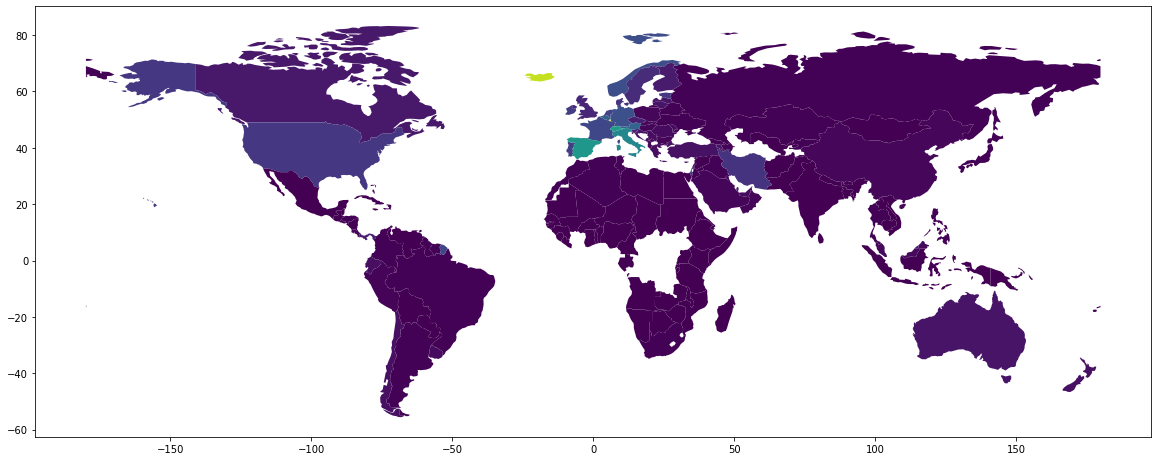

In [37]:
fig,ax= plt.subplots(figsize=(20,30))
#fig.title('total number of cases per milion inhabitants')
#fig.legend()
world_global_confirmed.plot(column = 'normalized' , ax = ax) 
#world_global_confirmed.loc[:,['name','normilized','geometry']].plot(column ='normalized' , ax = ax )